# Projet n°6 - Détectez des faux billets

## Import des modules de base

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Import du dataset

In [2]:
df = pd.read_csv('data_p_6.csv')

In [3]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


## Analyse univariée

In [4]:
df.info()
# Aucune valeur manquante
# 6 variables de type 'float'
# 1 variable de type booléen

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [5]:
df.describe()
# On note des différences assez élevées entre les moyennes, notamment entre les variables "margin_low" et "margin_up" et les autres variables
# Les écart-types sont compris entre 0.29 et 0.93. C'est un rapport de 3:1 entre le plus petit écart-type et le plus grand

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


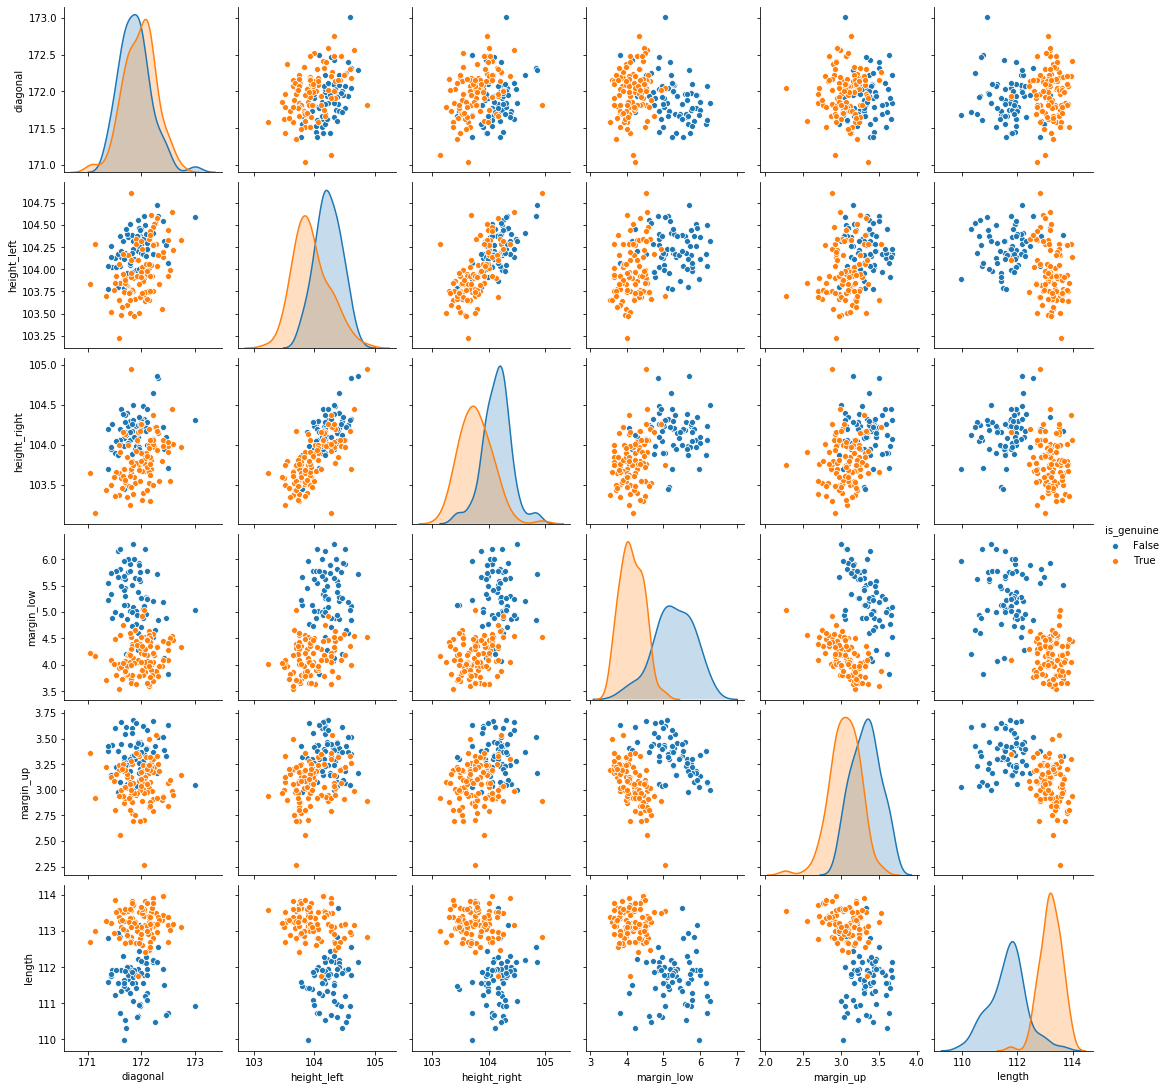

In [6]:
sns.pairplot(data=df, hue='is_genuine')
plt.savefig('Matrice_des_correlations')
plt.show()
# Matrice des analyses univariées et bivariées

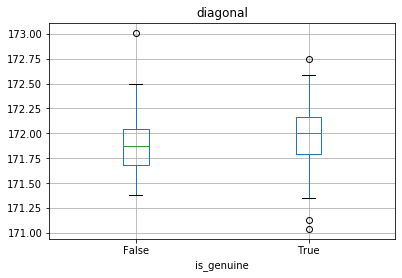

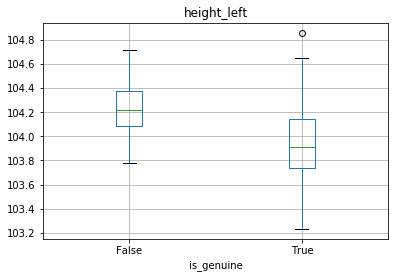

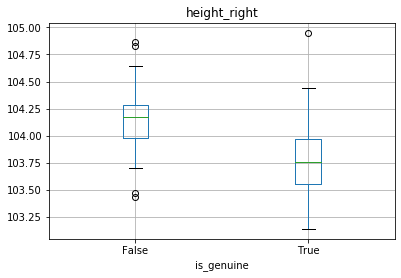

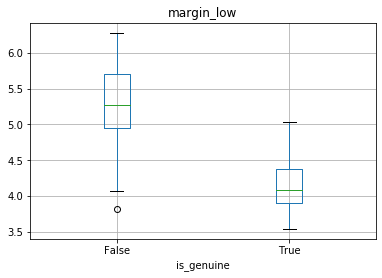

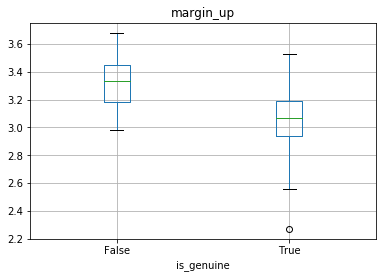

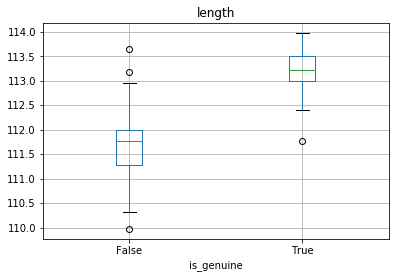

In [7]:
# boxplots en utilisant "is_genuine" comme variable illustrative
for var in df.columns[1:]:
    df.boxplot(column=var, by='is_genuine', showfliers=True, grid=True)
    plt.savefig('boxplot_{}'.format(var))
    plt.suptitle(None)

## Analyse en Composantes Principales

### Import des modules

In [8]:
from sklearn import decomposition 
from sklearn import preprocessing
import numpy as np

### Fonctions pour les différents éléments de la PCA

In [9]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None, title=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.savefig(title)
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, title=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.savefig(title)
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [10]:
np.array(df['is_genuine'])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [11]:
dfs = df.drop('is_genuine', axis=1) # on crée un DF sans la variable "is_genuine" qui sera utilisé comme variable illustrative

In [12]:
n = dfs.shape[0] #nombre d'observations
p = dfs.shape[1] #nombre de variables

In [13]:
X = dfs.values # Extraction des valeurs
features = dfs.columns # Extraction des noms de variables
names = dfs.index # Extraction des noms de pays

In [14]:
X.shape

(170, 6)

In [15]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [16]:
# Centrage et sans réduction
std_scale2 = preprocessing.StandardScaler(with_std=False).fit(X)
X_scaled2 = std_scale2.transform(X)

In [17]:
# nombre de composantes égale au nombre de variables utilisées
n_comp=6

In [18]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [19]:
# variance expliquée
print(pca.explained_variance_)

[2.86372065 1.32522178 0.85912514 0.51460481 0.27840703 0.19442354]


In [20]:
# variance corrigée
eigval = (n-1)/n*pca.explained_variance_
print(eigval)

[2.84687523 1.31742636 0.85407146 0.51157773 0.27676935 0.19327987]


### PCA avec tous les plans factoriels

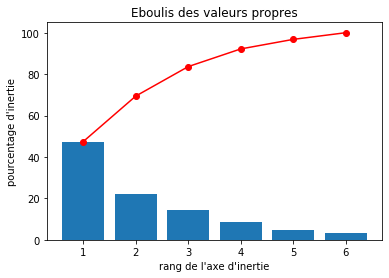

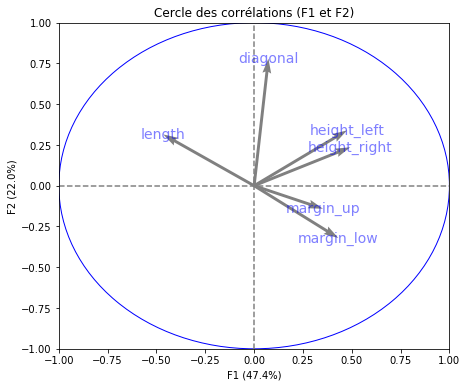

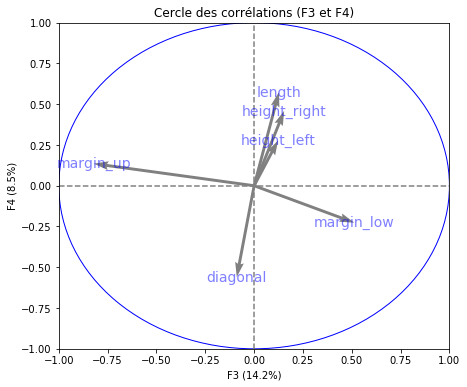

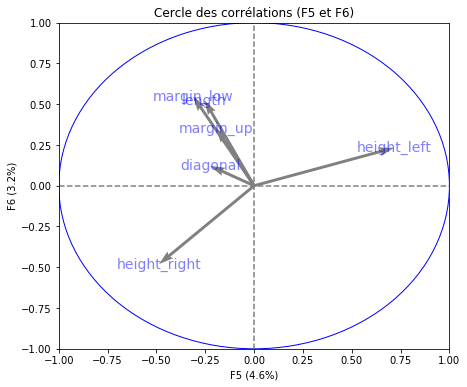

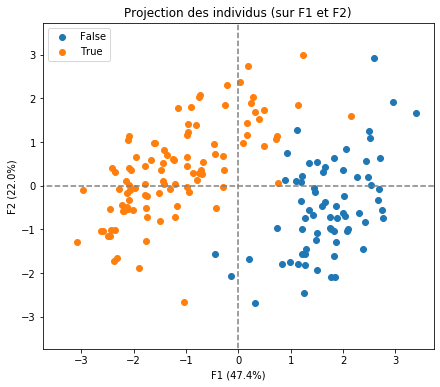

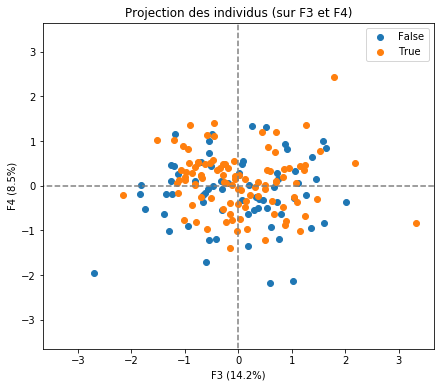

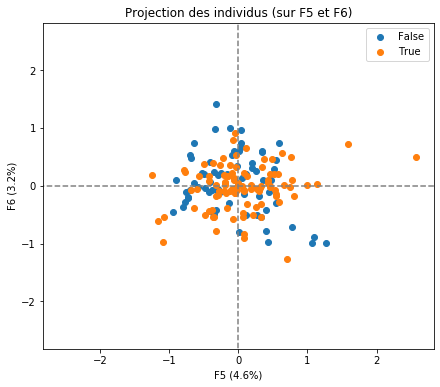

In [21]:
# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features), title='Cercles_corr')

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], illustrative_var=df['is_genuine'], title='Projection_indiv')

plt.show()

### PCA : Premier plan factoriel

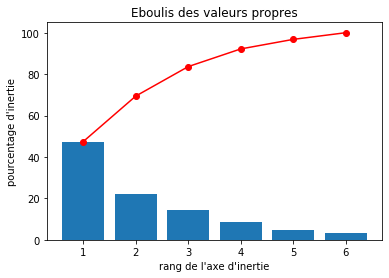

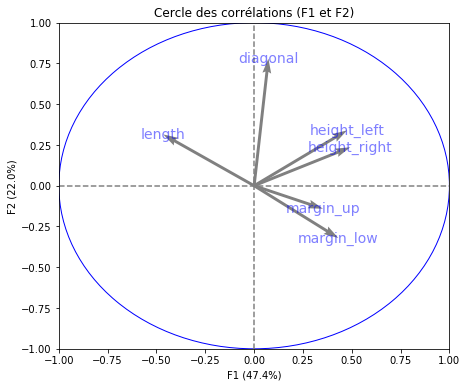

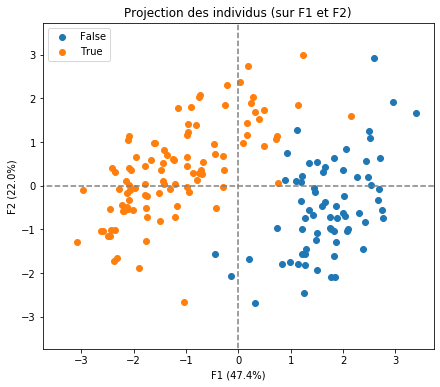

In [22]:
# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features), title='Cercle_des_ind')

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=df['is_genuine'], title='Projection_indiv_1')

plt.show()

# Qualité de représentation

### Individus

In [23]:
#contribution des individus dans l'inertie totale
di = np.sum(X_scaled**2,axis=1)
display(pd.DataFrame({'ID':dfs.index,'d_i':di}).sort_values(ascending=False, by='d_i'))

# On met au ² les X_scaled et on fait la somme de chaque individu. 
# Si la somme est proche de 0, l'individu est dans la moyenne, à l'inverse s'il est éloigné de 0, il se démarque.
# Les billets 166 et 0 sont ceux qui se démarquent le plus des autres

,ID,d_i
166,166,20.625650
0,0,18.410598
4,4,18.039567
122,122,16.790944
39,39,15.052608
...,...,...
59,59,1.484454
76,76,1.435202
85,85,1.431664
98,98,0.878319


In [24]:
cos2 = X_projected**2
for j in range(p):
    cos2[:,j] = cos2[:,j]/di
display(pd.DataFrame({'id':dfs.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}))

# On divise la coordonnéee² des individus sur chaque axe (coté adjacent) par sa contribution totale (hypothènuse) pour obtenir le cos²
# Plus un cos² est proche de 1, plus l'individu va être fortement représenté sur un axe

,id,COS2_1,COS2_2
0,0,0.251929,0.139000
1,1,0.818002,0.050822
2,2,0.784862,0.000466
3,3,0.882856,0.001652
4,4,0.320145,0.009417
...,...,...,...
165,165,0.800651,0.004703
166,166,0.324059,0.411824
167,167,0.498809,0.083461
168,168,0.156908,0.271800


In [25]:
#vérifions la théorie - somme en ligne des cos2 = 1
print(np.sum(cos2,axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [26]:
#contributions aux axes
ctr = X_projected**2
for j in range(p):
 ctr[:,j] = ctr[:,j]/(n*eigval[j])

display(pd.DataFrame({'id':dfs.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]}).sort_values(ascending=False, by=['CTR_1' , 'CTR_2']))

# On calcul la distance sur l'axe des abcisses d'un individu par rapport à l'inertie d'un axe

,id,CTR_1,CTR_2
122,122,0.023758,0.012372
49,49,0.019620,0.007487
29,29,0.018089,0.000038
112,112,0.017950,0.016259
158,158,0.015836,0.002423
...,...,...,...
78,78,0.000059,0.006047
12,12,0.000053,0.009140
152,152,0.000038,0.018910
27,27,0.000014,0.004179


## Visualisation

### Contribution à l'inertie totale

In [27]:
# Création d'un DF
qual = pd.DataFrame({'id':dfs.index,'d_i':di,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1],'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]})

In [28]:
# Classement des 10 individus avec les valeurs les plus élevées
qual.sort_values('d_i', ascending=False).head(10)

,id,d_i,CTR_1,CTR_2,COS2_1,COS2_2
166,166,20.625650,0.013811,0.037927,0.324059,0.411824
0,0,18.410598,0.009584,0.011426,0.251929,0.139000
4,4,18.039567,0.011933,0.000759,0.320145,0.009417
122,122,16.790944,0.023758,0.012372,0.684788,0.165025
39,39,15.052608,0.007440,0.015917,0.239212,0.236828
112,112,14.422407,0.017950,0.016259,0.602347,0.252487
151,151,13.637281,0.003251,0.026922,0.115366,0.442138
49,49,12.917538,0.019620,0.007487,0.735094,0.129814
160,160,12.831169,0.001823,0.002458,0.068742,0.042901
158,158,12.724639,0.015836,0.002423,0.602309,0.042652


In [29]:
# Classement des 10 individus avec les valeurs les plus faibles
qual.sort_values('d_i').head(10)

,id,d_i,CTR_1,CTR_2,COS2_1,COS2_2
64,64,0.813929,0.001067,0.000568,0.634384,0.156187
98,98,0.878319,0.000930,0.001294,0.512439,0.329905
85,85,1.431664,0.001968,0.000865,0.665326,0.135337
76,76,1.435202,0.000987,0.000307,0.332832,0.047900
59,59,1.484454,0.001999,0.001908,0.651764,0.287865
83,83,1.659976,0.000434,0.004015,0.126488,0.541731
32,32,1.716885,0.001565,0.000364,0.441113,0.047519
46,46,1.777577,0.003534,0.000027,0.962296,0.003343
58,58,1.809956,0.000419,0.002422,0.111922,0.299712
41,41,1.829743,0.001810,0.000081,0.478842,0.009959


In [30]:
# seuil des 10eme
qual['d_i_top_10'] = qual['d_i'] > 10.72
qual['d_i_bot_10'] = qual['d_i'] < 1.83

In [31]:
# création d'un score
qual['top_bot'] = qual['d_i_top_10']*2 + qual['d_i_bot_10']

In [32]:
# création d'un dictionnaire pour map les scores
topbot = {0 : 'autres individus', 2 :'Individus qui contribuent le plus', 1 :'Individus qui contribuent le moins'}
qual['top_bot'] = qual['top_bot'].map(topbot)

In [33]:
qual

,id,d_i,CTR_1,CTR_2,COS2_1,COS2_2,d_i_top_10,d_i_bot_10,top_bot
0,0,18.410598,0.009584,0.011426,0.251929,0.139000,True,False,Individus qui contribuent le plus
1,1,5.444799,0.009203,0.001236,0.818002,0.050822,False,False,autres individus
2,2,4.960527,0.008045,0.000010,0.784862,0.000466,False,False,autres individus
3,3,4.805719,0.008767,0.000035,0.882856,0.001652,False,False,autres individus
4,4,18.039567,0.011933,0.000759,0.320145,0.009417,True,False,Individus qui contribuent le plus
...,...,...,...,...,...,...,...,...,...
165,165,7.673233,0.012694,0.000161,0.800651,0.004703,False,False,autres individus
166,166,20.625650,0.013811,0.037927,0.324059,0.411824,True,False,Individus qui contribuent le plus
167,167,8.567410,0.008830,0.003193,0.498809,0.083461,False,False,autres individus
168,168,3.482926,0.001129,0.004227,0.156908,0.271800,False,False,autres individus


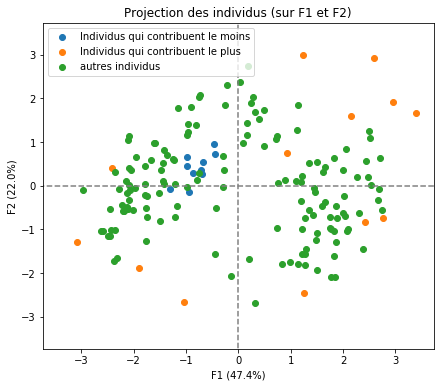

In [34]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=qual['top_bot'], title='Projection_indiv_inertie_totale')
plt.show()

### Contribution des invidus aux axes

In [35]:
pd.DataFrame({'id':dfs.index,'d_i':di,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1],'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]})

,id,d_i,CTR_1,CTR_2,COS2_1,COS2_2
0,0,18.410598,0.009584,0.011426,0.251929,0.139000
1,1,5.444799,0.009203,0.001236,0.818002,0.050822
2,2,4.960527,0.008045,0.000010,0.784862,0.000466
3,3,4.805719,0.008767,0.000035,0.882856,0.001652
4,4,18.039567,0.011933,0.000759,0.320145,0.009417
...,...,...,...,...,...,...
165,165,7.673233,0.012694,0.000161,0.800651,0.004703
166,166,20.625650,0.013811,0.037927,0.324059,0.411824
167,167,8.567410,0.008830,0.003193,0.498809,0.083461
168,168,3.482926,0.001129,0.004227,0.156908,0.271800


In [36]:
qual.sort_values('CTR_1', ascending=False).head(10)

,id,d_i,CTR_1,CTR_2,COS2_1,COS2_2,d_i_top_10,d_i_bot_10,top_bot
122,122,16.790944,0.023758,0.012372,0.684788,0.165025,True,False,Individus qui contribuent le plus
49,49,12.917538,0.019620,0.007487,0.735094,0.129814,True,False,Individus qui contribuent le plus
29,29,10.117561,0.018089,0.000038,0.865269,0.000833,False,False,autres individus
112,112,14.422407,0.017950,0.016259,0.602347,0.252487,True,False,Individus qui contribuent le plus
158,158,12.724639,0.015836,0.002423,0.602309,0.042652,True,False,Individus qui contribuent le plus
101,101,8.249495,0.015483,0.001385,0.908310,0.037607,False,False,autres individus
147,147,10.500350,0.015085,0.001778,0.695295,0.037931,False,False,autres individus
121,121,10.584966,0.014871,0.000033,0.679947,0.000688,False,False,autres individus
146,146,8.432900,0.014783,0.000500,0.848412,0.013268,False,False,autres individus
7,7,9.344338,0.014226,0.004831,0.736813,0.115779,False,False,autres individus


In [37]:
qual['CTR_1_top_10'] = qual['CTR_1'] > 0.0142

In [38]:
qual.sort_values('CTR_2', ascending=False).head(10)

,id,d_i,CTR_1,CTR_2,COS2_1,COS2_2,d_i_top_10,d_i_bot_10,top_bot,CTR_1_top_10
5,5,11.527985,0.003155,0.039736,0.132447,0.771985,True,False,Individus qui contribuent le plus,False
166,166,20.625650,0.013811,0.037927,0.324059,0.411824,True,False,Individus qui contribuent le plus,False
34,34,8.374589,0.000073,0.033302,0.004225,0.890595,False,False,autres individus,False
156,156,7.862470,0.000211,0.032264,0.013014,0.919036,False,False,autres individus,False
70,70,11.048897,0.002197,0.031516,0.096228,0.638835,True,False,Individus qui contribuent le plus,False
151,151,13.637281,0.003251,0.026922,0.115366,0.442138,True,False,Individus qui contribuent le plus,False
21,21,6.020373,0.000002,0.025151,0.000164,0.935643,False,False,autres individus,False
23,23,6.233965,0.000088,0.023682,0.006820,0.850794,False,False,autres individus,False
131,131,8.616709,0.006470,0.019298,0.363368,0.501595,False,False,autres individus,False
153,153,10.557970,0.006999,0.019276,0.320822,0.408887,False,False,autres individus,False


In [39]:
qual['CTR_2_top_10'] = qual['CTR_2'] > 0.01927

In [40]:
qual['CTR_top_10'] = qual['CTR_1_top_10']*2 + qual['CTR_2_top_10']
qual['CTR_top_10'] = qual['CTR_top_10'].map({0 : 'autres individus', 2 :'Individus qui contribuent le plus à l\'axe F1', 1 :'Individus qui contribuent le plus à l\'axe F2'})

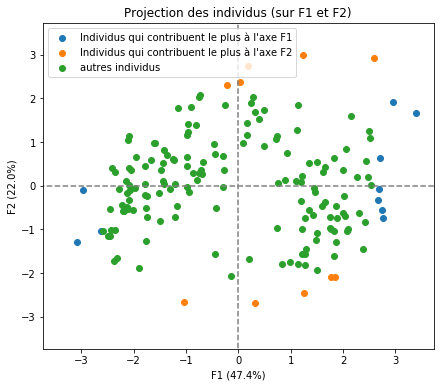

In [41]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=qual['CTR_top_10'], title='Projection_indiv_contri_axe')
plt.show()

### Qualité de représentation des individus par rapport aux axes

In [42]:
qual.sort_values('COS2_1', ascending=False).head(10)

,id,d_i,CTR_1,CTR_2,COS2_1,COS2_2,d_i_top_10,d_i_bot_10,top_bot,CTR_1_top_10,CTR_2_top_10,CTR_top_10
143,143,5.272310,0.010605,0.000179,0.973456,0.007584,False,False,autres individus,False,False,autres individus
46,46,1.777577,0.003534,0.000027,0.962296,0.003343,False,True,Individus qui contribuent le moins,False,False,autres individus
101,101,8.249495,0.015483,0.001385,0.908310,0.037607,False,False,autres individus,True,False,Individus qui contribuent le plus à l'axe F1
94,94,4.965243,0.009296,0.001014,0.906118,0.045729,False,False,autres individus,False,False,autres individus
123,123,6.603207,0.012345,0.001393,0.904783,0.047258,False,False,autres individus,False,False,autres individus
90,90,5.423688,0.010065,0.001488,0.898122,0.061454,False,False,autres individus,False,False,autres individus
111,111,4.422536,0.008197,0.000571,0.896997,0.028916,False,False,autres individus,False,False,autres individus
132,132,4.605211,0.008426,0.000256,0.885530,0.012440,False,False,autres individus,False,False,autres individus
3,3,4.805719,0.008767,0.000035,0.882856,0.001652,False,False,autres individus,False,False,autres individus
105,105,2.416912,0.004409,0.000081,0.882824,0.007530,False,False,autres individus,False,False,autres individus


In [43]:
qual['COS2_1_top_10'] = qual['COS2_1'] > 0.8828
qual['COS2_1_top_10'] = qual['COS2_1_top_10'].map({False : 'autres individus', True :'Individus qui sont les mieux représentés sur à l\'axe F1'})

In [44]:
qual

,id,d_i,CTR_1,CTR_2,COS2_1,COS2_2,d_i_top_10,d_i_bot_10,top_bot,CTR_1_top_10,CTR_2_top_10,CTR_top_10,COS2_1_top_10
0,0,18.410598,0.009584,0.011426,0.251929,0.139000,True,False,Individus qui contribuent le plus,False,False,autres individus,autres individus
1,1,5.444799,0.009203,0.001236,0.818002,0.050822,False,False,autres individus,False,False,autres individus,autres individus
2,2,4.960527,0.008045,0.000010,0.784862,0.000466,False,False,autres individus,False,False,autres individus,autres individus
3,3,4.805719,0.008767,0.000035,0.882856,0.001652,False,False,autres individus,False,False,autres individus,Individus qui sont les mieux représentés sur à...
4,4,18.039567,0.011933,0.000759,0.320145,0.009417,True,False,Individus qui contribuent le plus,False,False,autres individus,autres individus
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,165,7.673233,0.012694,0.000161,0.800651,0.004703,False,False,autres individus,False,False,autres individus,autres individus
166,166,20.625650,0.013811,0.037927,0.324059,0.411824,True,False,Individus qui contribuent le plus,False,True,Individus qui contribuent le plus à l'axe F2,autres individus
167,167,8.567410,0.008830,0.003193,0.498809,0.083461,False,False,autres individus,False,False,autres individus,autres individus
168,168,3.482926,0.001129,0.004227,0.156908,0.271800,False,False,autres individus,False,False,autres individus,autres individus


In [45]:
qual.sort_values('COS2_2', ascending=False).head(10)

,id,d_i,CTR_1,CTR_2,COS2_1,COS2_2,d_i_top_10,d_i_bot_10,top_bot,CTR_1_top_10,CTR_2_top_10,CTR_top_10,COS2_1_top_10
21,21,6.020373,0.000002,0.025151,0.000164,0.935643,False,False,autres individus,False,True,Individus qui contribuent le plus à l'axe F2,autres individus
156,156,7.862470,0.000211,0.032264,0.013014,0.919036,False,False,autres individus,False,True,Individus qui contribuent le plus à l'axe F2,autres individus
33,33,4.558939,0.000162,0.018553,0.017244,0.911419,False,False,autres individus,False,False,autres individus,autres individus
34,34,8.374589,0.000073,0.033302,0.004225,0.890595,False,False,autres individus,False,True,Individus qui contribuent le plus à l'axe F2,autres individus
23,23,6.233965,0.000088,0.023682,0.006820,0.850794,False,False,autres individus,False,True,Individus qui contribuent le plus à l'axe F2,autres individus
36,36,4.977051,0.001134,0.018533,0.110271,0.833974,False,False,autres individus,False,False,autres individus,autres individus
53,53,4.358761,0.000124,0.015084,0.013805,0.775037,False,False,autres individus,False,False,autres individus,autres individus
5,5,11.527985,0.003155,0.039736,0.132447,0.771985,True,False,Individus qui contribuent le plus,False,True,Individus qui contribuent le plus à l'axe F2,autres individus
26,26,5.940102,0.001098,0.019166,0.089474,0.722621,False,False,autres individus,False,False,autres individus,autres individus
22,22,4.114166,0.000224,0.012726,0.026330,0.692767,False,False,autres individus,False,False,autres individus,autres individus


In [46]:
qual['COS2_2_top_10'] = qual['COS2_2'] > 0.692
qual['COS2_2_top_10'] = qual['COS2_2_top_10'].map({False : 'autres individus', True :'Individus qui sont les mieux représentés sur à l\'axe F2'})

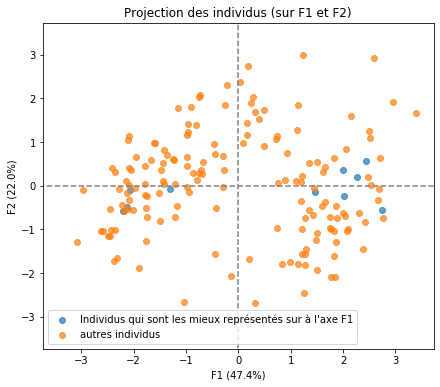

In [47]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], alpha=0.7, illustrative_var=qual['COS2_1_top_10'], title='Projection_indiv_représentation_F1')
plt.show()

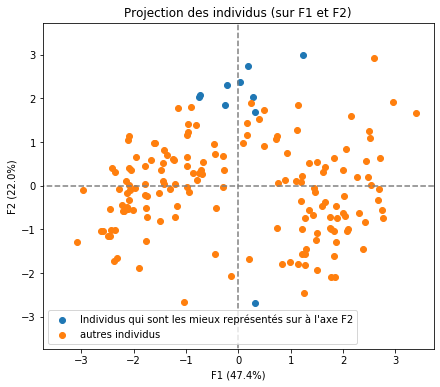

In [48]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=qual['COS2_2_top_10'], title='Projection_indiv_représentation_F2')
plt.show()

In [49]:
qual.sort_values('COS2_1', ascending=False).head(10)

,id,d_i,CTR_1,CTR_2,COS2_1,COS2_2,d_i_top_10,d_i_bot_10,top_bot,CTR_1_top_10,CTR_2_top_10,CTR_top_10,COS2_1_top_10,COS2_2_top_10
143,143,5.272310,0.010605,0.000179,0.973456,0.007584,False,False,autres individus,False,False,autres individus,Individus qui sont les mieux représentés sur à...,autres individus
46,46,1.777577,0.003534,0.000027,0.962296,0.003343,False,True,Individus qui contribuent le moins,False,False,autres individus,Individus qui sont les mieux représentés sur à...,autres individus
101,101,8.249495,0.015483,0.001385,0.908310,0.037607,False,False,autres individus,True,False,Individus qui contribuent le plus à l'axe F1,Individus qui sont les mieux représentés sur à...,autres individus
94,94,4.965243,0.009296,0.001014,0.906118,0.045729,False,False,autres individus,False,False,autres individus,Individus qui sont les mieux représentés sur à...,autres individus
123,123,6.603207,0.012345,0.001393,0.904783,0.047258,False,False,autres individus,False,False,autres individus,Individus qui sont les mieux représentés sur à...,autres individus
90,90,5.423688,0.010065,0.001488,0.898122,0.061454,False,False,autres individus,False,False,autres individus,Individus qui sont les mieux représentés sur à...,autres individus
111,111,4.422536,0.008197,0.000571,0.896997,0.028916,False,False,autres individus,False,False,autres individus,Individus qui sont les mieux représentés sur à...,autres individus
132,132,4.605211,0.008426,0.000256,0.885530,0.012440,False,False,autres individus,False,False,autres individus,Individus qui sont les mieux représentés sur à...,autres individus
3,3,4.805719,0.008767,0.000035,0.882856,0.001652,False,False,autres individus,False,False,autres individus,Individus qui sont les mieux représentés sur à...,autres individus
105,105,2.416912,0.004409,0.000081,0.882824,0.007530,False,False,autres individus,False,False,autres individus,Individus qui sont les mieux représentés sur à...,autres individus


## Variables

In [50]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

In [51]:
#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
 corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]

#afficher la matrice des corrélations variables x facteurs
print(corvar)

[[ 0.1236346   0.89486346 -0.08215244 -0.40034612 -0.11841965  0.05370861]
 [ 0.80229967  0.38938864  0.11345001  0.19887167  0.37663775  0.10205336]
 [ 0.8298348   0.27035382  0.14216371  0.32825381 -0.25620145 -0.21138296]
 [ 0.72725782 -0.36790977  0.4739162  -0.16202319 -0.1640912   0.24075808]
 [ 0.59482939 -0.1619761  -0.75887278  0.09680115 -0.10203101  0.15579811]
 [-0.78520903  0.36102241  0.11728832  0.41033916 -0.13384583  0.23034781]]


In [52]:
#cosinus carré des variables
cos2var = corvar**2
print(pd.DataFrame({'id':dfs.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]}))

             id    COS2_1    COS2_2
0      diagonal  0.015286  0.800781
1   height_left  0.643685  0.151624
2  height_right  0.688626  0.073091
3    margin_low  0.528904  0.135358
4     margin_up  0.353822  0.026236
5        length  0.616553  0.130337


In [53]:
F1 = pca.components_[0]
print(F1)

[ 0.07327499  0.47550205  0.4918214   0.43102671  0.35253984 -0.46537288]


In [54]:
F2 = pca.components_[1]
print(F2)

[ 0.77963908  0.33925019  0.23554253 -0.32053699 -0.14111974  0.31453645]


In [55]:
dfs.columns

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

In [56]:
# Résumé des deux premiers axes d'inertie dans un date frame
var = dfs.columns
combi_lin = pd.DataFrame({'Variables':var,'F1':F1, 'F2':F2})
combi_lin = combi_lin.set_index('Variables')
combi_lin

,F1,F2
Variables,,
diagonal,0.073275,0.779639
height_left,0.475502,0.339250
height_right,0.491821,0.235543
margin_low,0.431027,-0.320537
margin_up,0.352540,-0.141120
length,-0.465373,0.314536


In [57]:
#contributions
ctrvar = cos2var
for k in range(p):
    ctrvar[:,k] = ctrvar[:,k]/eigval[k] 
#on n'affiche que pour les deux premiers axes
print(pd.DataFrame({'id':dfs.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]}))

             id     CTR_1     CTR_2
0      diagonal  0.005369  0.607837
1   height_left  0.226102  0.115091
2  height_right  0.241888  0.055480
3    margin_low  0.185784  0.102744
4     margin_up  0.124284  0.019915
5        length  0.216572  0.098933


# Kmeans

In [58]:
# import
from sklearn import metrics
from sklearn.cluster import KMeans

#### Méthode du coude

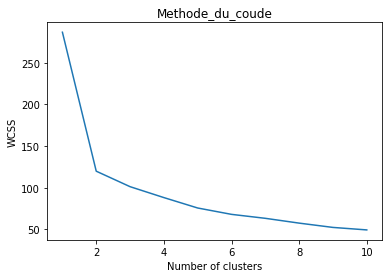

In [59]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X) # utilisation des variables non scales
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Methode_du_coude')
plt.show()

In [60]:
y = df['is_genuine'] # y variable qui détermine si un billet est vrai ou faux

In [61]:
# Préparation
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=500, n_init=10, random_state=0)

## Prédictions sur les valeurs centrées/réduites

In [62]:
pred_y = kmeans.fit_predict(X_scaled) 

In [63]:
pred_y = (pred_y * -1) + 1
# Transformation de la matrice, inversion des 0 et des 1

### Matrice de confusion

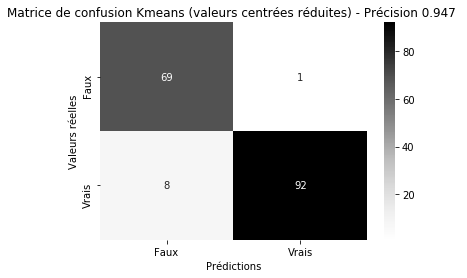

In [64]:
cnf_matrix = metrics.confusion_matrix(y, pred_y)
cnf_matrix = pd.DataFrame(cnf_matrix)
percent_pred = (cnf_matrix.iloc[0,0] + cnf_matrix.iloc[1,1]) / sum(sum(cnf_matrix.values))
cnf_matrix.columns = ['Faux', 'Vrais']
cnf_matrix.index = ['Faux', 'Vrais']
sns.heatmap(cnf_matrix, annot=True, cmap='Greys')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion Kmeans (valeurs centrées réduites) - Précision %1.3f ' %percent_pred)
plt.savefig('Matrice_de_confusion_kmeans_scale')
plt.show()

In [65]:
df['kmean_pred_scale'] = pred_y

In [66]:
df['confusion_scale'] = df['is_genuine'] *2 + df['kmean_pred_scale']
df

# Vrai-vrai = 3 (2*1 + 1)
# Vrai-faux = 2 (2*1 + 0)
# Faux-Faux = 0 (0 + 0)
# Faux-vrai = 1 (0 + 1)


df['confusion_scale'] = df['confusion_scale'].map({0 : 'Faux classé faux', 1 :'Faux classé vrai', 2: 'Vrai classé faux', 3:'Vrai classé vrai'})

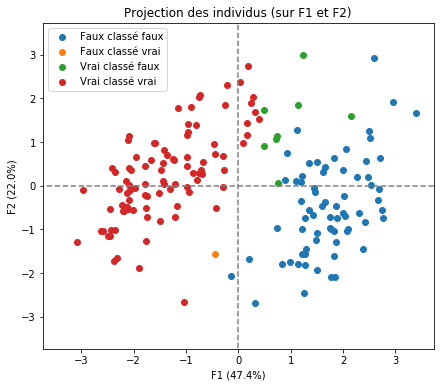

In [67]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=df['confusion_scale'], title='Projection_indiv_kmeans_scale')
plt.show()

## Prédictions sur les valeurs non mise à l'échelle

In [68]:
pred_y3 = kmeans.fit_predict(X_scaled2)

In [69]:
pred_y3 = (pred_y3 * -1) + 1
# Transformation de la matrice, inversion des 0 et des 1
# objectif = que les vrais soient égalent à 1 et les faux à 0

### Matrice de confusion

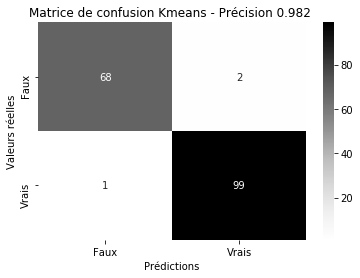

In [70]:
cnf_matrix2 = metrics.confusion_matrix(y, pred_y3)
cnf_matrix2 = pd.DataFrame(cnf_matrix2)
percent_pred2 = (cnf_matrix2.iloc[0,0] + cnf_matrix2.iloc[1,1]) / sum(sum(cnf_matrix2.values))
cnf_matrix2.columns = ['Faux', 'Vrais']
cnf_matrix2.index = ['Faux', 'Vrais']
sns.heatmap(cnf_matrix2, annot=True, cmap='Greys')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion Kmeans - Précision %1.3f ' %percent_pred2)
plt.savefig('Matrice_de_confusion_no_scale')


In [71]:
df['kmean_pred'] = pred_y3

In [72]:
df['confusion'] = df['is_genuine'] *2 + df['kmean_pred']
df

# Vrai-vrai = 3 (2*1 + 1)
# Vrai-faux = 2 (2*1 + 0)
# Faux-Faux = 0 (0 + 0)
# Faux-vrai = 1 (0 + 1)

df['confusion'] = df['confusion'].map({0 : 'Faux classé faux', 1 :'Faux classé vrai', 2: 'Vrai classé faux', 3:'Vrai classé vrai'})

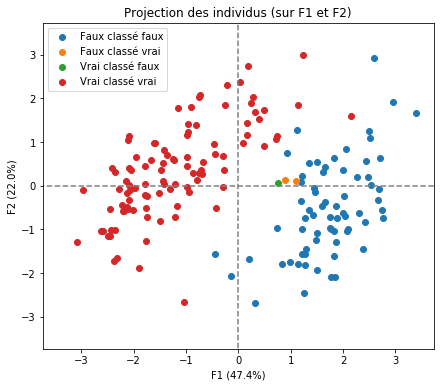

In [73]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=df['confusion'], title='Projection_indiv_no_scale')
plt.show()

# Régression logistique

In [74]:
import scipy.optimize as opt

In [75]:
from scipy.special import expit

## Valeurs mises à l'échelle

In [76]:
from sklearn.model_selection import train_test_split

# Création d'un partitionnement, on entraîne le modèle sur 75% des données et on le test sur les 25% restant
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.25,random_state=0)

In [77]:
# import
from sklearn.linear_model import LogisticRegression

# instanciation du modèle
logreg = LogisticRegression()

# fit le modèle avec les données
logreg.fit(X_train,y_train)

# prédictions
y_pred=logreg.predict(X_test)

In [78]:
# Calcul des coefs
coef = logreg.coef_
coef

array([[ 0.09634024, -0.24305316, -0.50344641, -2.13663962, -1.4338282 ,
         1.6917558 ]])

In [79]:
# Calcul de l'ordonnée à l'origine
intercept = logreg.intercept_

In [80]:
# Mise en application de la formule de la régression logistique
z = X_scaled @ coef.T + intercept
y2 = 1 / (1 + np.exp(-z))

In [81]:
# création d'une liste de 170 chiffres où les 100 premiers chiffres sont 1 et les 70 derniers sont 0
one = np.ones(100)
zero = np.ones(70) -1
label = np.hstack((one,zero))

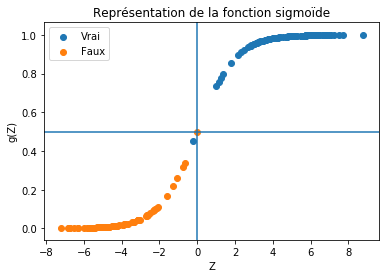

In [82]:
# Représentation graphique de la fonction sigmoïde
plt.scatter(z[:100],y2[:100], label='Vrai')
plt.scatter(z[100:],y2[100:], label='Faux')
plt.axvline(0)
plt.axhline(0.5)
plt.title('Représentation de la fonction sigmoïde')
plt.xlabel('Z')
plt.ylabel('g(Z)')
plt.legend()
plt.savefig('sigmoid')
plt.show()

In [83]:
# Prédiction sur l'ensemble du DF
y_pred2 = logreg.predict(X_scaled)

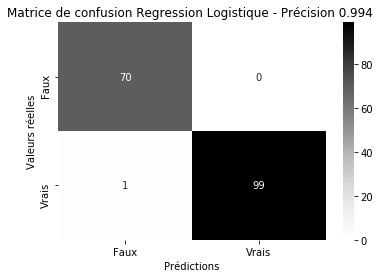

In [84]:
# Matrice de confusion 
cnf_matrix3 = metrics.confusion_matrix(y, y_pred2)
cnf_matrix3 = pd.DataFrame(cnf_matrix3)
percent_pred3 = (cnf_matrix3.iloc[0,0] + cnf_matrix3.iloc[1,1]) / sum(sum(cnf_matrix3.values))
cnf_matrix3.columns = ['Faux', 'Vrais']
cnf_matrix3.index = ['Faux', 'Vrais']
sns.heatmap(cnf_matrix3, annot=True, cmap='Greys')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion Regression Logistique - Précision %1.3f ' %percent_pred3)
plt.savefig('Matrice_de_confusion_reg')
plt.show()


In [85]:
# Création des variables illustratives
df['reg_pred'] = y_pred2
df['confusion_reg'] = df['is_genuine'] *2 + df['reg_pred']

# Vrai-vrai = 3 (2*1 + 1)
# Vrai-faux = 2 (2*1 + 0)
# Faux-Faux = 0 (0 + 0)
# Faux-vrai = 1 (0 + 1)

df['confusion_reg'] = df['confusion_reg'].map({0 : 'Faux classé faux', 1 :'Faux classé vrai', 2: 'Vrai classé faux', 3:'Vrai classé vrai'})

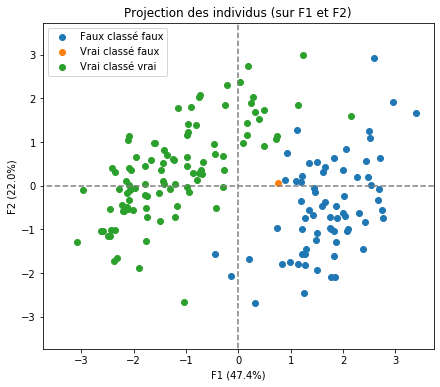

In [86]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=df['confusion_reg'], title='Projection_indiv_reg')

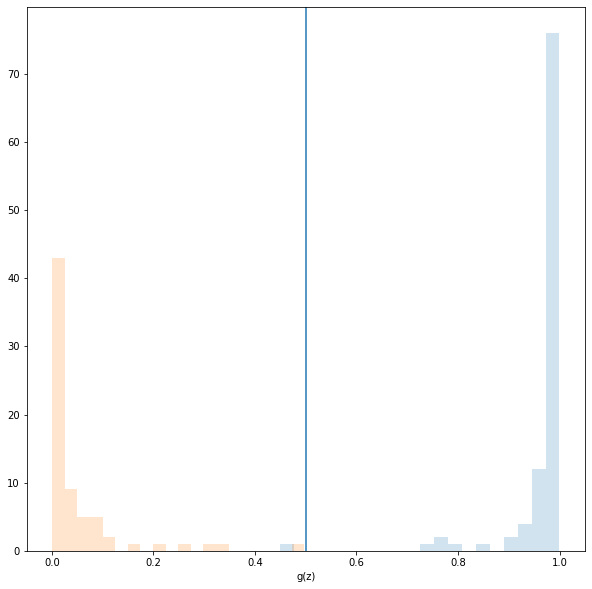

In [87]:
# les 100 premiers sont vrais
plt.figure(figsize=(10,10))
plt.hist(y2[:100], alpha=0.2, bins=20)
plt.hist(y2[100:], alpha=0.2, bins=20)
plt.axvline(0.5)
plt.xlabel('g(z)')
plt.savefig('Histogramme_double_des_predictions')
plt.show()

## Valeurs non mise à l'échelle

In [88]:
# Voir commentaire à la section précédente

In [89]:
X_train2,X_test2,y_train2,y_test2=train_test_split(X,y,test_size=0.25,random_state=0)
logreg2 = LogisticRegression()
logreg2.fit(X_train2,y_train2)
y_pred3=logreg2.predict(X_test2)
coef2 = logreg2.coef_
intercept2 = logreg2.intercept_
z2 = X @ coef2.T + intercept2
y3 = 1 / (1 + np.exp(-z2))

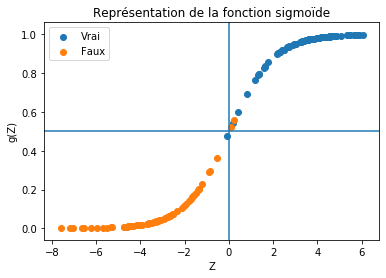

In [90]:
plt.scatter(z2[:100],y3[:100], label='Vrai')
plt.scatter(z2[100:],y3[100:], label='Faux')
plt.axvline(0)
plt.axhline(0.5)
plt.title('Représentation de la fonction sigmoïde')
plt.xlabel('Z')
plt.ylabel('g(Z)')
plt.legend()
plt.savefig('sigmoid_2')
plt.show()

In [91]:
y_pred3 = logreg2.predict(X)

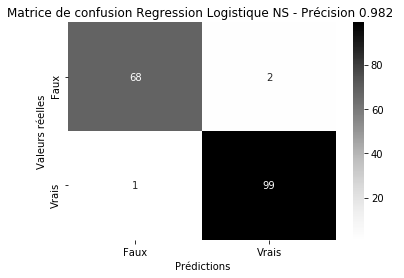

In [92]:
cnf_matrix4 = metrics.confusion_matrix(y, y_pred3)
cnf_matrix4 = pd.DataFrame(cnf_matrix4)
percent_pred4 = (cnf_matrix4.iloc[0,0] + cnf_matrix4.iloc[1,1]) / sum(sum(cnf_matrix4.values))
cnf_matrix4.columns = ['Faux', 'Vrais']
cnf_matrix4.index = ['Faux', 'Vrais']
sns.heatmap(cnf_matrix4, annot=True, cmap='Greys')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion Regression Logistique NS - Précision %1.3f ' %percent_pred4)
plt.savefig('Matrice_de_confusion_reg')
plt.show()

In [93]:
df['reg_pred_ns'] = y_pred3
df['confusion_reg_ns'] = df['is_genuine'] *2 + df['reg_pred_ns']

# Vrai-vrai = 3 (2*1 + 1)
# Vrai-faux = 2 (2*1 + 0)
# Faux-Faux = 0 (0 + 0)
# Faux-vrai = 1 (0 + 1)

df['confusion_reg_ns'] = df['confusion_reg_ns'].map({0 : 'Faux classé faux', 1 :'Faux classé vrai', 2: 'Vrai classé faux', 3:'Vrai classé vrai'})

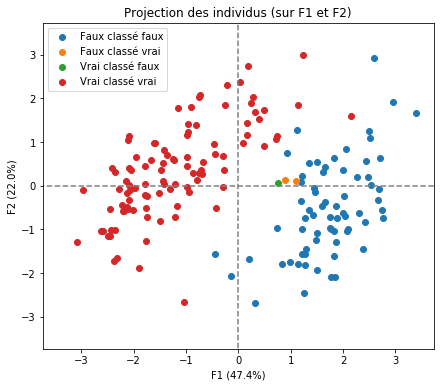

In [94]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=df['confusion_reg_ns'], title='Projection_indiv_reg_ns')

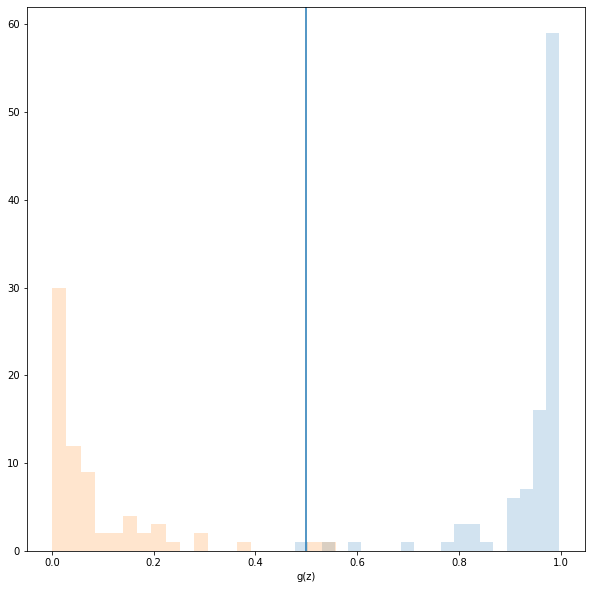

In [95]:
# les 100 premiers sont vrais
plt.figure(figsize=(10,10))
plt.hist(y3[:100], alpha=0.2, bins=20)
plt.hist(y3[100:], alpha=0.2, bins=20)
plt.axvline(0.5)
plt.xlabel('g(z)')
plt.savefig('Histogramme_double_des_predictions')
plt.show()

## Programme de test

In [96]:
# Nom du fichier à modifier
test = pd.read_csv('example.csv')

In [97]:
# Aperçu du DF
test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [98]:
# Préparation des données
Z = test.iloc[:,:-1].values # Extraction des valeurs sans la colonne id
std_scale_z = preprocessing.StandardScaler().fit(Z)
Z_scaled = std_scale_z.transform(Z)

In [99]:
# Calcul des probabilités
# la première probabilité est celle qu'un billet soit vrai
# la deuxième probabilité est celle qu'un billet soit faux
# la somme des deux probas est égale à 1
probas = logreg.predict_proba(Z_scaled)
probas

array([[8.47036094e-01, 1.52963906e-01],
       [9.73011275e-01, 2.69887247e-02],
       [9.59456967e-01, 4.05430332e-02],
       [2.48136561e-03, 9.97518634e-01],
       [2.76262210e-04, 9.99723738e-01]])

In [100]:
# Affichage des résultats dans un dataframe
test['proba_vrai'] = probas[:,0]
test['proba_faux'] = probas[:,1]
test['billet_vrai'] = test['proba_vrai'] > 0.5
test

,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba_vrai,proba_faux,billet_vrai
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.847036,0.152964,True
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.973011,0.026989,True
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.959457,0.040543,True
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.002481,0.997519,False
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.000276,0.999724,False


In [101]:
# Affichage du taux de précision
taux_precision = sum(test['billet_vrai']) / len(test)
taux_precision

0.6